# Feature Selection for Uplift Modeling
  
    
This notebook includes two sections:  
- **Feature selection**: demonstrate how to use Filter methods to select the most important numeric features
- **Performance evaluation**: evaluate the AUUC performance with top features dataset
  
*(Paper reference: [Zhao, Zhenyu, et al. "Feature Selection Methods for Uplift Modeling." arXiv preprint arXiv:2005.03447 (2020).](https://arxiv.org/abs/2005.03447))*

In [1]:
import numpy as np
import pandas as pd

In [2]:
from causalml.dataset import make_uplift_classification

#### Import FilterSelect class for Filter methods

In [3]:
from causalml.feature_selection.filters import FilterSelect

In [4]:
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [6]:
import logging

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

### Generate dataset

Generate synthetic data using the built-in function.

In [7]:
# define parameters for simulation

y_name = 'conversion'
treatment_group_keys = ['control', 'treatment1']
n = 100000
n_classification_features = 50
n_classification_informative = 10
n_classification_repeated = 0
n_uplift_increase_dict = {'treatment1': 8}
n_uplift_decrease_dict = {'treatment1': 4}
delta_uplift_increase_dict = {'treatment1': 0.1}
delta_uplift_decrease_dict = {'treatment1': -0.1}

random_seed = 20200808

In [8]:
df, X_names = make_uplift_classification(
    treatment_name=treatment_group_keys,
    y_name=y_name,
    n_samples=n,
    n_classification_features=n_classification_features,
    n_classification_informative=n_classification_informative,
    n_classification_repeated=n_classification_repeated,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict = delta_uplift_increase_dict, 
    delta_uplift_decrease_dict = delta_uplift_decrease_dict,
    random_seed=random_seed
)

In [9]:
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_informative,x7_informative,x8_informative,x9_informative,...,x56_uplift_increase,x57_uplift_increase,x58_uplift_increase,x59_increase_mix,x60_uplift_decrease,x61_uplift_decrease,x62_uplift_decrease,x63_uplift_decrease,conversion,treatment_effect
0,control,0.653960,-0.217603,1.856916,-0.075662,0.080971,-0.338374,-1.011470,0.528000,0.115418,...,1.533832,-2.183001,1.839608,0.755302,1.835047,-0.458431,-1.927525,2.765331,0,0
1,control,3.439658,0.477855,-0.377658,-1.317121,0.861815,-0.393180,0.503727,2.323846,1.229948,...,-1.192333,-1.581815,2.423700,2.396904,0.296043,-1.961940,-1.444725,1.469213,1,0
2,treatment1,0.130907,-0.333536,0.474847,-0.352067,-0.024502,1.437105,0.566178,-0.232508,0.866236,...,-0.301982,-0.933816,0.475274,1.540994,0.698066,0.545091,-0.084405,-2.337347,1,0
3,treatment1,-2.156683,1.120198,0.174293,-1.741426,0.488993,0.638340,-0.721928,1.802134,1.097178,...,-2.129098,-1.183581,0.000318,1.105735,-0.629281,-0.737041,-1.525081,1.416042,0,0
4,control,-2.708572,-0.799698,-2.199595,0.574077,0.083142,-0.389140,1.492101,1.725202,1.194315,...,1.582041,-1.176077,1.686322,0.480035,1.780710,0.862094,0.128872,-2.851344,0,0


In [10]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.499050,100000
treatment1,0.599680,100000
All,0.549365,200000


In [11]:
X_names

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_informative',
 'x7_informative',
 'x8_informative',
 'x9_informative',
 'x10_informative',
 'x11_irrelevant',
 'x12_irrelevant',
 'x13_irrelevant',
 'x14_irrelevant',
 'x15_irrelevant',
 'x16_irrelevant',
 'x17_irrelevant',
 'x18_irrelevant',
 'x19_irrelevant',
 'x20_irrelevant',
 'x21_irrelevant',
 'x22_irrelevant',
 'x23_irrelevant',
 'x24_irrelevant',
 'x25_irrelevant',
 'x26_irrelevant',
 'x27_irrelevant',
 'x28_irrelevant',
 'x29_irrelevant',
 'x30_irrelevant',
 'x31_irrelevant',
 'x32_irrelevant',
 'x33_irrelevant',
 'x34_irrelevant',
 'x35_irrelevant',
 'x36_irrelevant',
 'x37_irrelevant',
 'x38_irrelevant',
 'x39_irrelevant',
 'x40_irrelevant',
 'x41_irrelevant',
 'x42_irrelevant',
 'x43_irrelevant',
 'x44_irrelevant',
 'x45_irrelevant',
 'x46_irrelevant',
 'x47_irrelevant',
 'x48_irrelevant',
 'x49_irrelevant',
 'x50_irrelevant',
 'x51_uplift_increase',
 'x52_uplift_increase',
 

## Feature selection with Filter methods

### method = F (F statistics)

In [12]:
filter_f = FilterSelect() 

In [13]:
method = 'F'
f_imp = filter_f.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1')
print(f_imp)

      method              feature  rank        score        p_value  \
0   F filter  x57_uplift_increase   1.0  1973.380496   0.000000e+00   
0   F filter  x51_uplift_increase   2.0  1885.342364   0.000000e+00   
0   F filter  x54_uplift_increase   3.0  1496.254091   0.000000e+00   
0   F filter  x58_uplift_increase   4.0  1269.167710  4.224019e-277   
0   F filter       x9_informative   5.0   677.066204  5.151887e-149   
..       ...                  ...   ...          ...            ...   
0   F filter       x30_irrelevant  59.0     0.004151   9.486301e-01   
0   F filter       x50_irrelevant  60.0     0.001379   9.703808e-01   
0   F filter       x36_irrelevant  61.0     0.001062   9.740069e-01   
0   F filter       x6_informative  62.0     0.000428   9.834997e-01   
0   F filter       x5_informative  63.0     0.000076   9.930457e-01   

                               misc  
0   df_num: 1.0, df_denom: 199996.0  
0   df_num: 1.0, df_denom: 199996.0  
0   df_num: 1.0, df_denom: 199996

### method = LR (likelihood ratio test)

In [14]:
method = 'LR'
lr_imp = filter_f.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1')
print(lr_imp)

Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
  

Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683126
  

### method = KL (KL divergence)

In [15]:

method = 'KL'
kl_imp = filter_f.get_importance(df, X_names, y_name, method, 
                      treatment_group = 'treatment1',
                      n_bins=10)
print(kl_imp)

       method              feature  rank     score p_value                misc
0   KL filter  x51_uplift_increase   1.0  0.026008    None  number_of_bins: 10
0   KL filter  x57_uplift_increase   2.0  0.023749    None  number_of_bins: 10
0   KL filter       x9_informative   3.0  0.020550    None  number_of_bins: 10
0   KL filter  x54_uplift_increase   4.0  0.018411    None  number_of_bins: 10
0   KL filter  x58_uplift_increase   5.0  0.014443    None  number_of_bins: 10
..        ...                  ...   ...       ...     ...                 ...
0   KL filter       x29_irrelevant  59.0  0.000021    None  number_of_bins: 10
0   KL filter       x30_irrelevant  60.0  0.000020    None  number_of_bins: 10
0   KL filter       x17_irrelevant  61.0  0.000017    None  number_of_bins: 10
0   KL filter       x45_irrelevant  62.0  0.000013    None  number_of_bins: 10
0   KL filter       x7_informative  63.0  0.000011    None  number_of_bins: 10

[63 rows x 6 columns]


We found all these 3 filter methods were able to rank most of the **informative** and **uplift increase** features on the top.

## Performance evaluation  

Evaluate the AUUC (Area Under the Uplift Curve) score with several uplift models when using top features dataset 

In [16]:
# train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [17]:
# convert treatment column to 1 (treatment1) and 0 (control)
treatments = np.where((df_test['treatment_group_key']=='treatment1'), 1, 0)
print(treatments[:10])
print(df_test['treatment_group_key'][:10])

[1 0 0 0 0 1 0 1 1 0]
79114     treatment1
76043        control
47617        control
53169        control
175702       control
111635    treatment1
129212       control
19247     treatment1
49272     treatment1
199314       control
Name: treatment_group_key, dtype: object


### Uplift RandomForest Classfier

In [18]:
uplift_model = UpliftRandomForestClassifier(control_name='control', max_depth=8)

In [19]:
# using all features
features = X_names 
uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds = uplift_model.predict(df_test[features].values)

### Select top N features based on KL filter

In [20]:
top_n = 10
top_10_features = kl_imp['feature'][:top_n]
print(top_10_features)

0    x51_uplift_increase
0    x57_uplift_increase
0         x9_informative
0    x54_uplift_increase
0    x58_uplift_increase
0    x52_uplift_increase
0    x55_uplift_increase
0         x23_irrelevant
0       x59_increase_mix
0         x21_irrelevant
Name: feature, dtype: object


In [21]:
top_n = 15
top_15_features = kl_imp['feature'][:top_n]
print(top_15_features)

0    x51_uplift_increase
0    x57_uplift_increase
0         x9_informative
0    x54_uplift_increase
0    x58_uplift_increase
0    x52_uplift_increase
0    x55_uplift_increase
0         x23_irrelevant
0       x59_increase_mix
0         x21_irrelevant
0         x15_irrelevant
0         x11_irrelevant
0         x46_irrelevant
0         x39_irrelevant
0    x53_uplift_increase
Name: feature, dtype: object


In [22]:
top_n = 20
top_20_features = kl_imp['feature'][:top_n]
print(top_20_features)

0    x51_uplift_increase
0    x57_uplift_increase
0         x9_informative
0    x54_uplift_increase
0    x58_uplift_increase
0    x52_uplift_increase
0    x55_uplift_increase
0         x23_irrelevant
0       x59_increase_mix
0         x21_irrelevant
0         x15_irrelevant
0         x11_irrelevant
0         x46_irrelevant
0         x39_irrelevant
0    x53_uplift_increase
0        x10_informative
0         x2_informative
0         x31_irrelevant
0         x19_irrelevant
0         x40_irrelevant
Name: feature, dtype: object


#### Train the Uplift model again with top N features

In [23]:
# using top 10 features
features = top_10_features 

uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t10 = uplift_model.predict(df_test[features].values)

In [24]:
# using top 15 features
features = top_15_features 

uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t15 = uplift_model.predict(df_test[features].values)

In [25]:
# using top 20 features
features = top_20_features

uplift_model.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t20 = uplift_model.predict(df_test[features].values)

### Print results for Uplift model

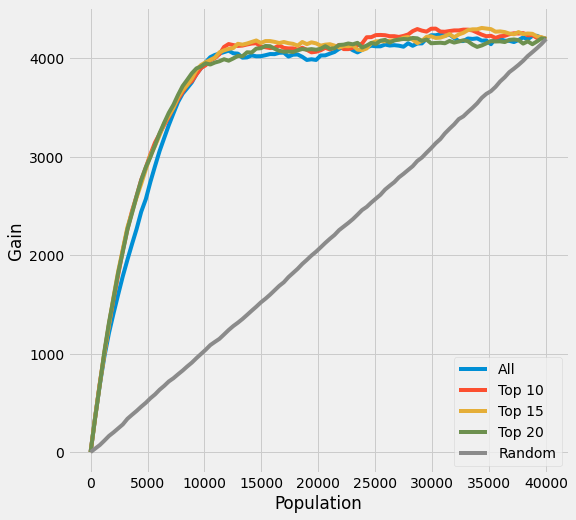

In [26]:
df_preds = pd.DataFrame([y_preds.ravel(), 
                         y_preds_t10.ravel(),
                         y_preds_t15.ravel(),
                         y_preds_t20.ravel(),
                         treatments,
                         df_test[y_name].ravel()],
                        index=['All', 'Top 10', 'Top 15', 'Top 20', 'is_treated', y_name]).T

plot_gain(df_preds, outcome_col=y_name, treatment_col='is_treated')


In [27]:
auuc_score(df_preds, outcome_col=y_name, treatment_col='is_treated')

All       0.883113
Top 10    0.902750
Top 15    0.903005
Top 20    0.894030
Random    0.493027
dtype: float64

### R Learner as base and feed in Random Forest Regressor

In [28]:
r_rf_learner = BaseRRegressor(
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf = 100
    ), 
control_name='control') 

In [29]:
# using all features
features = X_names 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


In [30]:
# using top 10 features
features = top_10_features 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t10 = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


In [31]:
# using top 15 features
features = top_15_features 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t15 = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


In [32]:
# using top 20 features
features = top_20_features 
r_rf_learner.fit(X = df_train[features].values, 
                 treatment = df_train['treatment_group_key'].values,
                 y = df_train[y_name].values)
y_preds_t20 = r_rf_learner.predict(df_test[features].values)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment1 with R-loss


### Print results for R Learner

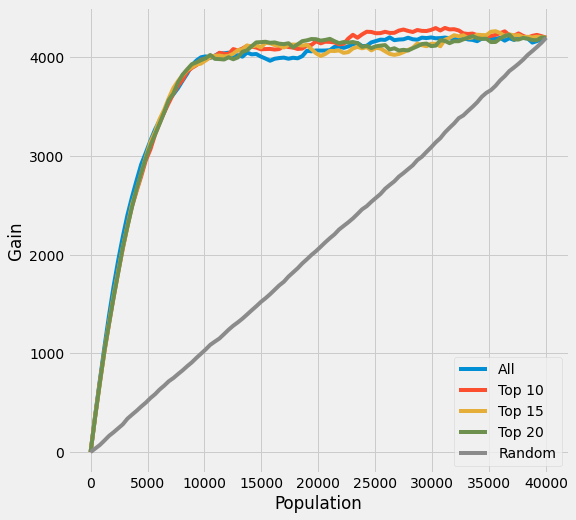

In [33]:
df_preds = pd.DataFrame([y_preds.ravel(), 
                         y_preds_t10.ravel(),
                         y_preds_t15.ravel(),
                         y_preds_t20.ravel(),
                         treatments,
                         df_test[y_name].ravel()],
                        index=['All', 'Top 10', 'Top 15', 'Top 20', 'is_treated', y_name]).T

plot_gain(df_preds, outcome_col=y_name, treatment_col='is_treated')

In [34]:
# print out AUUC score
auuc_score(df_preds, outcome_col=y_name, treatment_col='is_treated')

All       0.898363
Top 10    0.906834
Top 15    0.897248
Top 20    0.898664
Random    0.493027
dtype: float64

(a relatively smaller enhancement on the AUUC is observed in this R Learner case)

### S Learner as base and feed in Random Forest Regressor

In [35]:
slearner_rf = BaseSRegressor(
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf = 100
    ), 
    control_name='control')

In [36]:
# using all features
features = X_names 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds = slearner_rf.predict(df_test[features].values)

In [37]:
# using top 10 features
features = top_10_features 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds_t10 = slearner_rf.predict(df_test[features].values)

In [38]:
# using top 15 features
features = top_15_features 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds_t15 = slearner_rf.predict(df_test[features].values)

In [39]:
# using top 20 features
features = top_20_features 
slearner_rf.fit(X = df_train[features].values, 
                treatment = df_train['treatment_group_key'].values,
                y = df_train[y_name].values)
y_preds_t20 = slearner_rf.predict(df_test[features].values)

### Print results for S Learner

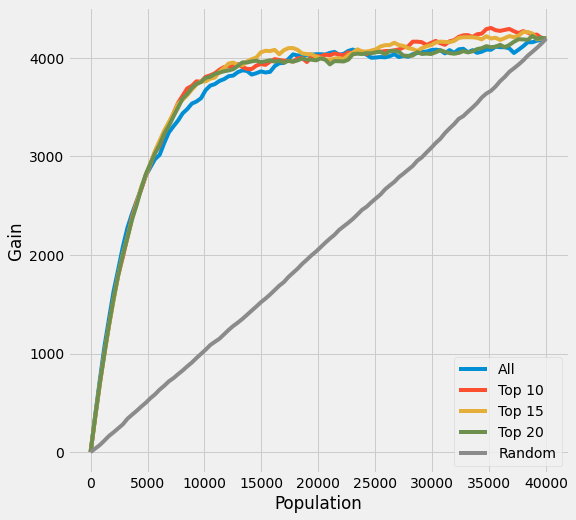

In [40]:
df_preds = pd.DataFrame([y_preds.ravel(), 
                         y_preds_t10.ravel(),
                         y_preds_t15.ravel(),
                         y_preds_t20.ravel(),
                         treatments,
                         df_test[y_name].ravel()],
                        index=['All', 'Top 10', 'Top 15', 'Top 20', 'is_treated', y_name]).T

plot_gain(df_preds, outcome_col=y_name, treatment_col='is_treated')

In [41]:
# print out AUUC score
auuc_score(df_preds, outcome_col=y_name, treatment_col='is_treated')

All       0.866137
Top 10    0.882310
Top 15    0.882737
Top 20    0.871582
Random    0.493027
dtype: float64

In this notebook, we demonstrated how our Filter method functions are able to select important features and enhance the AUUC performance (while the results might vary among different datasets, models and hyper-parameters).